In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from nltk.lm import Vocabulary
from tqdm import tqdm
from functools import reduce

In [2]:
import sys
sys.path.append('../scripts/')
from char_lstm import CharLSTM, pad

In [3]:
opus = pd.read_pickle("../data/raw/opus_sentences.pkl")
print(opus.shape)
opus.head()

(108017, 3)


,file,order,text
0,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,0,Source: librosgratis.liblit.com/
1,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,1,LAS AVENTURAS DE SHERLOCK HOLMES
2,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,2,Arthur Conan Doyle
3,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,3,1.
4,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,4,Escándalo en Bohemia


In [4]:
vocabulary = set("".join(opus["text"].to_list()))

In [5]:
char_to_ix = {k:i for i, k in enumerate(vocabulary, 3)}
char_to_ix["<pad>"] = 0
char_to_ix["<bos>"] = 1
char_to_ix["<eos>"] = 2
len(char_to_ix)

136

In [6]:
ix_to_char = {char_to_ix[k]:k for k in char_to_ix.keys()}

# generate training data

In [7]:
def text_to_ix(text):
    return [1] + [char_to_ix[c] for c in text] + [2]

In [8]:
def ix_to_text(ixs):
    return "".join([ix_to_char[i] for i in ixs])

In [9]:
letters = list(sorted(vocabulary))

def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0,1,1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0,1,1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i+1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                #print(char_to_ix[random_letter])
                noisy_sentence.append(random_letter)
                #noisy_sentence.append(char_to_ix[random_letter])
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass     
        i += 1
    #return noisy_sentence
    return "".join(noisy_sentence)

noise_maker("Relocate, remove, or add characters to create spelling mistakes", 0.97)

'Relocate, remov,e o`r add char«acters to create spelling mistakes'

In [10]:
from timeit import default_timer

In [11]:
opus["text"].map(len).describe(percentiles = np.arange(0, 1, 0.1))

count    108017.000000
mean        108.709648
std          98.915442
min           1.000000
0%            1.000000
10%          22.000000
20%          35.000000
30%          49.000000
40%          65.000000
50%          83.000000
60%         103.000000
70%         129.000000
80%         163.000000
90%         222.000000
max        2249.000000
Name: text, dtype: float64

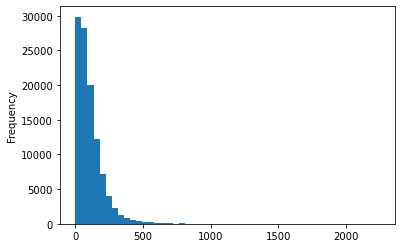

In [12]:
opus["text"].map(len).plot.hist(bins = 50)

In [13]:
noise_examples = 5
threshold = 0.95
sample_size = 12

start = default_timer()

preprocess = pd.DataFrame(opus["text"].sample(n = sample_size))\
.assign(noisy_sentences = lambda df: df["text"].map(lambda x:  [x] * 5 \
                                                    + [noise_maker(x, threshold) 
                                                       for i in range(noise_examples)]))\
.explode("noisy_sentences")\
.assign(X = lambda df: df["noisy_sentences"].map(text_to_ix),
        Y = lambda df: df["text"].map(text_to_ix))\
.reset_index(drop = True)

print(default_timer() - start)

print(preprocess.shape)
preprocess.head()

0.09756085899789468
(120, 4)


,text,noisy_sentences,X,Y
0,"Llegó la nube, le alcanzó y el montón de heno ...","Llegó la nube, le alcanzó y el montón de heno ...","[1, 73, 51, 25, 68, 41, 100, 51, 31, 100, 47, ...","[1, 73, 51, 25, 68, 41, 100, 51, 31, 100, 47, ..."
1,"Llegó la nube, le alcanzó y el montón de heno ...","Llegó la nube, le alcanzó y el montón de heno ...","[1, 73, 51, 25, 68, 41, 100, 51, 31, 100, 47, ...","[1, 73, 51, 25, 68, 41, 100, 51, 31, 100, 47, ..."
2,"Llegó la nube, le alcanzó y el montón de heno ...","Llegó la nube, le alcanzó y el montón de heno ...","[1, 73, 51, 25, 68, 41, 100, 51, 31, 100, 47, ...","[1, 73, 51, 25, 68, 41, 100, 51, 31, 100, 47, ..."
3,"Llegó la nube, le alcanzó y el montón de heno ...","Llegó la nube, le alcanzó y el montón de heno ...","[1, 73, 51, 25, 68, 41, 100, 51, 31, 100, 47, ...","[1, 73, 51, 25, 68, 41, 100, 51, 31, 100, 47, ..."
4,"Llegó la nube, le alcanzó y el montón de heno ...","Llegó la nube, le alcanzó y el montón de heno ...","[1, 73, 51, 25, 68, 41, 100, 51, 31, 100, 47, ...","[1, 73, 51, 25, 68, 41, 100, 51, 31, 100, 47, ..."


In [14]:
preprocess["X"].map(len).describe()

count    120.000000
mean     116.883333
std       67.051364
min        8.000000
25%       81.000000
50%      112.000000
75%      133.000000
max      289.000000
Name: X, dtype: float64

In [15]:
preprocess["Y"].map(len).describe()

count    120.000000
mean     117.000000
std       67.163415
min        9.000000
25%       80.750000
50%      113.000000
75%      132.750000
max      284.000000
Name: Y, dtype: float64

# model

100%|██████████| 20/20 [00:16<00:00,  1.24it/s]

Final loss: 1.633560299873352


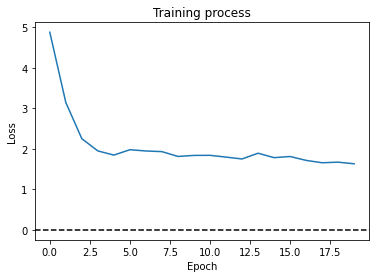

In [16]:
n = 16
net = CharLSTM(n, n, len(char_to_ix), 2)
losses = net.fit(preprocess["X"].values, preprocess["Y"].values)

Final loss: 1.5735361576080322


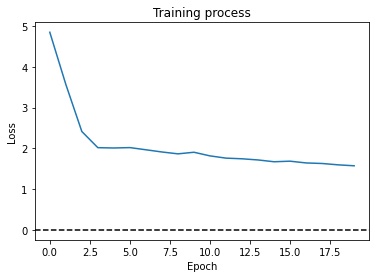

In [17]:
n = 16
net = CharLSTM(n, n, len(char_to_ix), 2)
losses = net.fit(preprocess["X"].values, preprocess["Y"].values, verbose = False)

100%|██████████| 20/20 [01:18<00:00,  3.92s/it]

Final loss: 0.9161575585603714


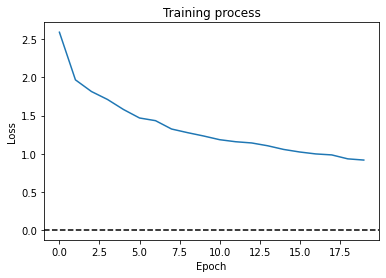

In [20]:
n = 16
net = CharLSTM(n, n, len(char_to_ix), 2)
losses = net.fit_batch(preprocess["X"].values, preprocess["Y"].values)

100%|██████████| 20/20 [01:15<00:00,  3.79s/it]

Final loss: 0.7655406668782234


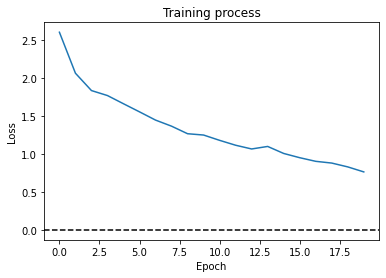

In [23]:
n = 16
net = CharLSTM(n, n, len(char_to_ix), 2)
losses = net.fit_batch(preprocess["X"].values, preprocess["Y"].values, save_path = "test_path.pt")

Final loss: 0.7677256042758623


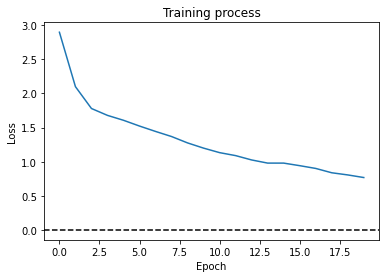

In [24]:
n = 16
net = CharLSTM(n, n, len(char_to_ix), 2)
losses = net.fit_batch(preprocess["X"].values, preprocess["Y"].values, 
                       verbose = False)

In [21]:
net.predict(preprocess["X"].values, preprocess["Y"].values).shape

torch.Size([120, 136, 283])

In [22]:
[b.shape for b in net.predict_batch(preprocess["X"].values, preprocess["Y"].values)]

[torch.Size([10, 136, 283]),
 torch.Size([10, 136, 43]),
 torch.Size([10, 136, 114]),
 torch.Size([10, 136, 8]),
 torch.Size([10, 136, 110]),
 torch.Size([10, 136, 79]),
 torch.Size([10, 136, 137]),
 torch.Size([10, 136, 100]),
 torch.Size([10, 136, 80]),
 torch.Size([10, 136, 130]),
 torch.Size([10, 136, 120]),
 torch.Size([10, 136, 188])]